# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score, 
                             mean_squared_error,
                             mean_absolute_error,
                             roc_auc_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             auc,
                             roc_curve,
                             RocCurveDisplay)
from sklearn.model_selection import train_test_split
from my_awesome_eda import run_eda

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда градиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [3]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что $w$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [4]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    
    return 2 * np.sin(w) * np.cos(w)

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [5]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [6]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= grad_f(curr_w) * lr # Не забудьте про lr!

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [7]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

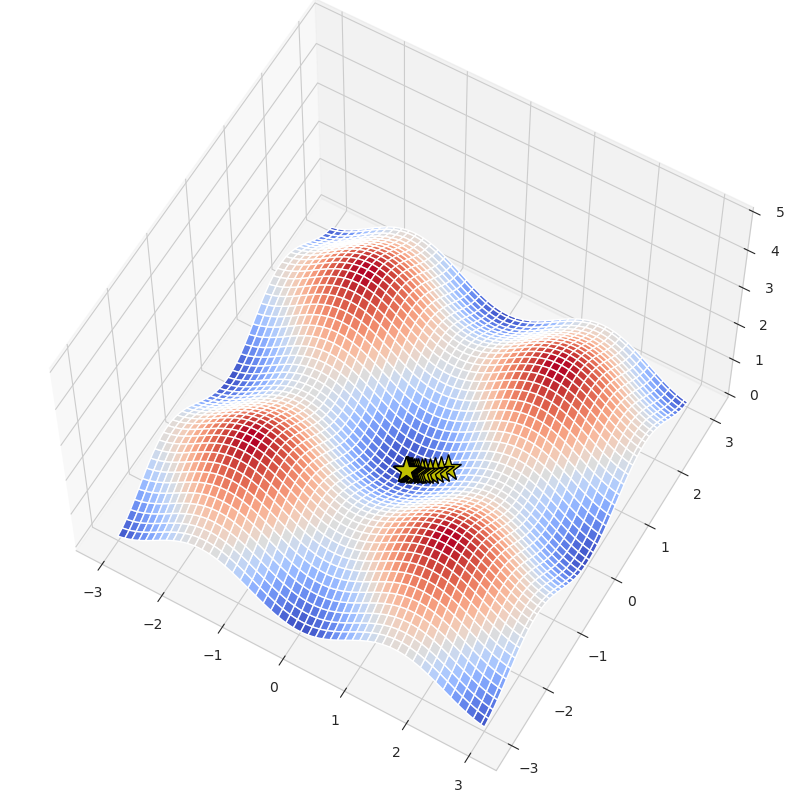

In [8]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

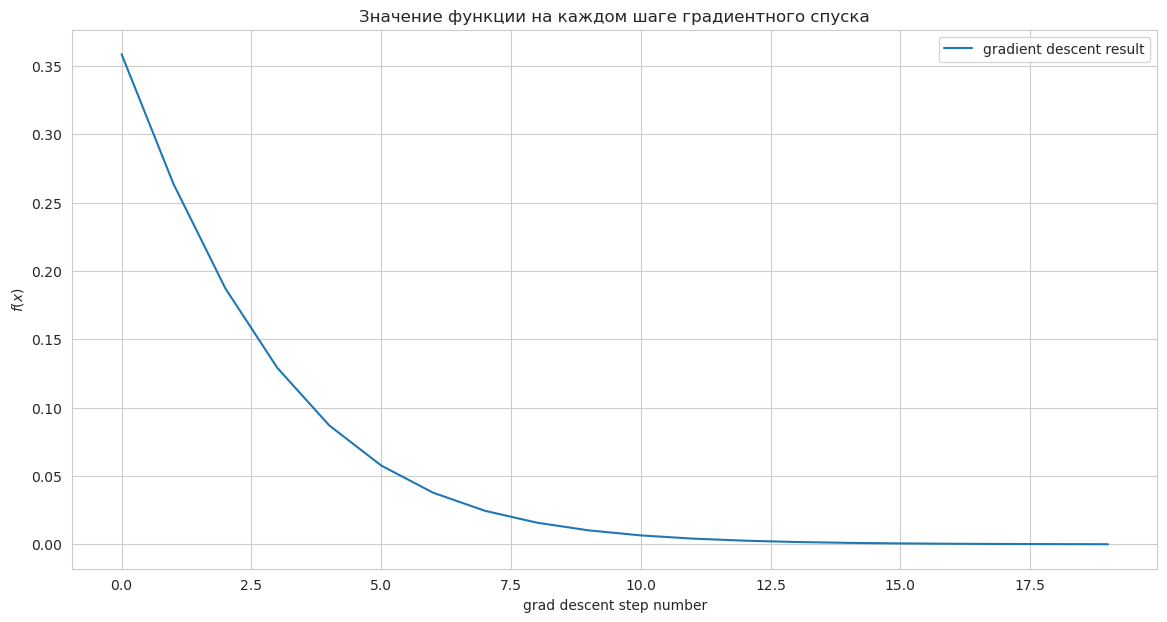

In [9]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге градиентного спуска")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [10]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    mse = 1/n * np.sum(np.square(y_true - y_pred))

    return mse


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    mse_grad = 2/n * (np.transpose(X) @ (y_pred - y_true))

    return mse_grad


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [11]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [12]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободный член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [13]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        y_pred = X_test @ self.W

        return y_pred
    
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [14]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

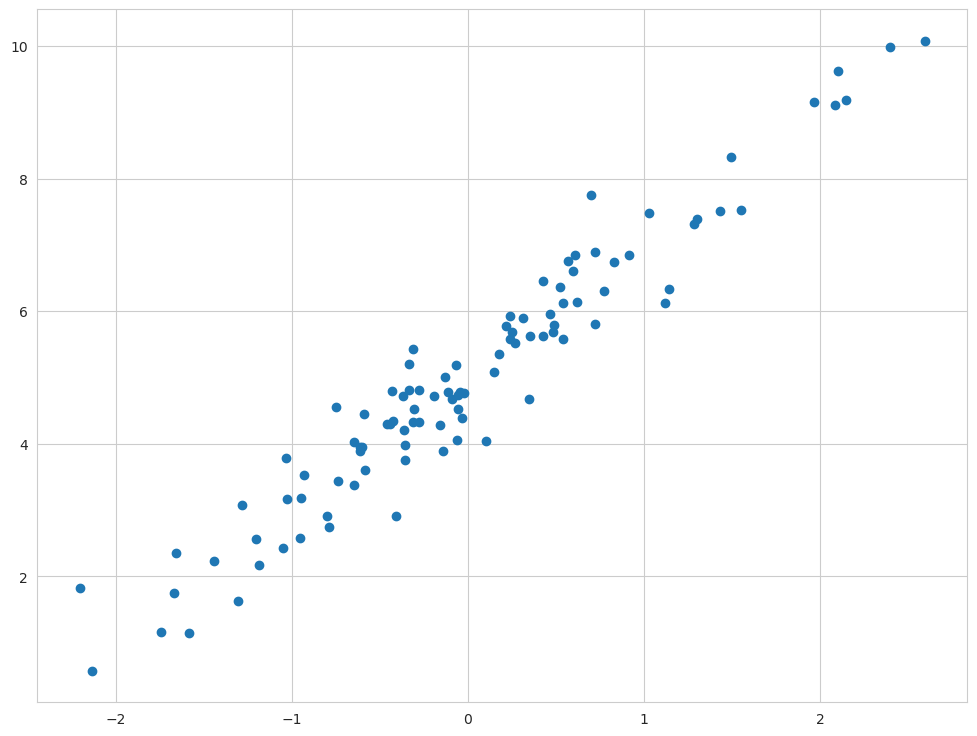

In [15]:
plt.scatter(X, y);

In [16]:
custom_lin_reg = CustomLinearRegression()

In [17]:
custom_lin_reg.fit(X, y)

My custom linear regression

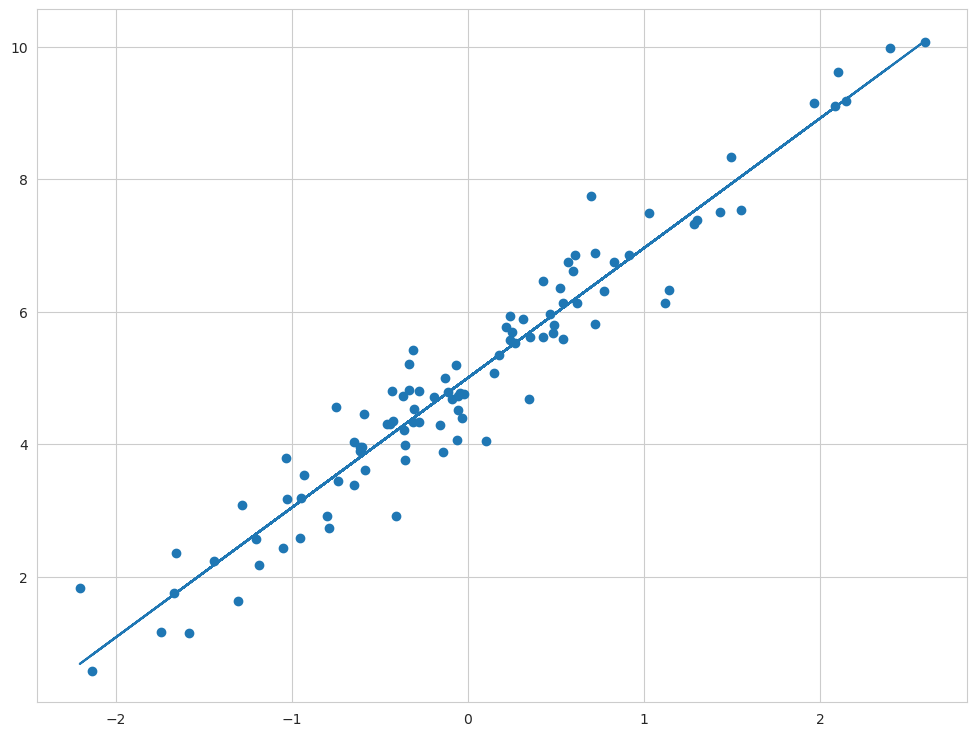

In [18]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Калифорнии. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [19]:
data = fetch_california_housing()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

Ваш ход:

#### EDA

In [20]:
X = pd.DataFrame(X, columns=feature_names)

Когда-нибудь я обязательно переделаю эту функцию и сделаю так, чтобы она нормально все выводила

Пока что я использую ее только, чтобы посмотреть на <u>выбросы</u>, т.к. в базовых функциях numpy этого нет, либо я не нашел просто

In [21]:
run_eda(X)

Viber! I mean WhatsApp... Sorry, Hello!

Your dataframe has 20640 rows and 8 columns.

List of column names and types:
  MedInc: float64 -- numerical
  HouseAge: float64 -- numerical
  AveRooms: float64 -- numerical
  AveBedrms: float64 -- numerical
  Population: float64 -- numerical
  AveOccup: float64 -- numerical
  Latitude: float64 -- numerical
  Longitude: float64 -- numerical

Dataframe has 0 factor features:

Dataframe has 8 numerical features:
  MedInc:
    Min: 0.4999
    Max: 15.0001
    Mean: 3.87
    Standart deviation: 1.90
    Quantile 1: 2.5633999999999997
    Median: 3.5347999999999997
    Quantile 3: 4.74325
    Number of outliers (+- 1.5 IQR): 1351
  HouseAge:
    Min: 1.0
    Max: 52.0
    Mean: 28.64
    Standart deviation: 12.59
    Quantile 1: 18.0
    Median: 29.0
    Quantile 3: 37.0
  AveRooms:
    Min: 0.8461538461538461
    Max: 141.9090909090909
    Mean: 5.43
    Standart deviation: 2.47
    Quantile 1: 4.440716235896959
    Median: 5.229128787878788
    Qu

In [22]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [23]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [24]:
X.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


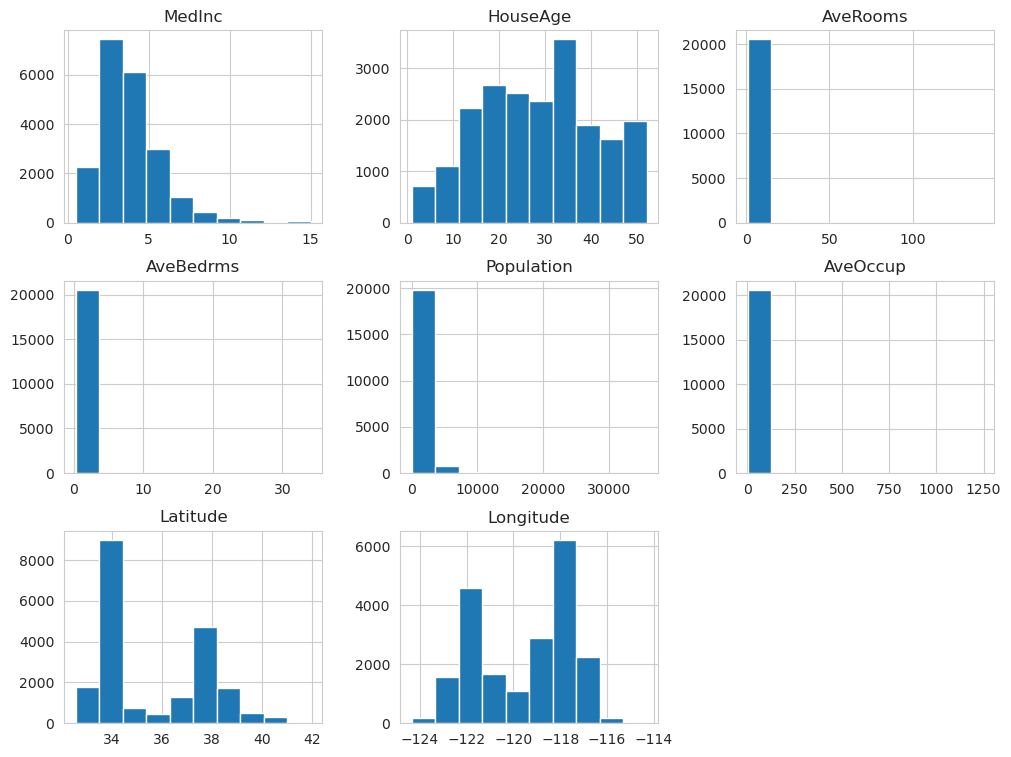

In [25]:
X.hist();

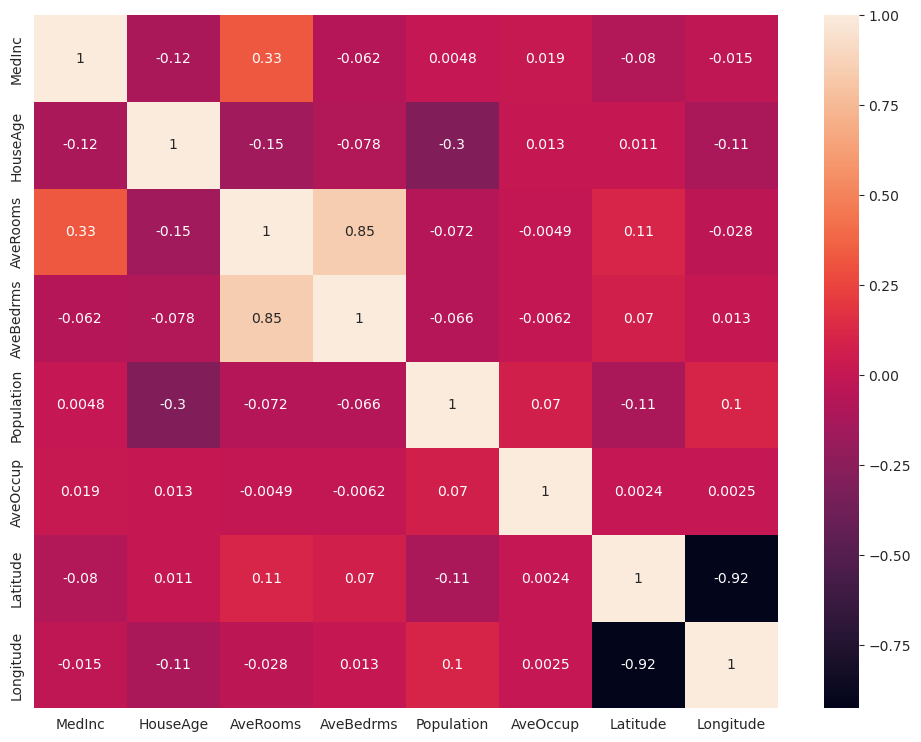

In [26]:
sns.heatmap(X.corr(), annot=True);

**Информация об атрибутах:**
- MedInc $-$ средний доход в "блоке"
- HouseAge $-$ средний возраст дома в "блоке"
- AveRooms $-$ среднее количество комнат
- AveBedrms $-$ среднее количество спален
- Population $-$ население "блокa"
- AveOccup $-$ средняя населенность дома
- Latitude $-$ широта "блокa"
- Longitude $-$ долгота "блокa"

**EDA саммари:**

- Все атрибуты численные, всего 8
- Пропущенных значений нет
- У всех признаков разные размерности $\rightarrow$ нужна стандартизация
- Очень много выбросов почти в каждом признаке, что заставляет задуматься о том, выбросы ли это
  + Если посмотреть, например, на кол-во комнат в среднем (AveRooms), то значения действительно сильно варьируют, поэтому <u>не будем ничего убирать</u>
  + Также можно заметить 2 пика на гистограммах у графиков широты и долготы, что говорит о разном местоположении "блоков" 
- В корреляционной матрице можно увидеть 2 корреляции:
  + "$+$" Среднее кол-во комнат и среднее кол-во спален $\rightarrow$ можем убрать спальни, потому что они тоже считаются комнатами
  + "$-$" Широта и долгота $\rightarrow$ можем убрать долготу, потому что только у нее отрцитальные значения
    > В целом не принципиально что убирать, насколько я понимаю

#### Построение модели

In [27]:
X_subset = X[['MedInc', 'HouseAge', 'AveRooms', 'Population', 'AveOccup', 'Latitude']]
X_subset_columns = X_subset.columns.tolist()

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_subset, 
                                                    y, 
                                                    test_size=0.3,
                                                    random_state=SEED)

In [29]:
linmod_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("linmod", LinearRegression(n_jobs=8))
])
linmod_pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('linmod', LinearRegression(n_jobs=8))])

In [30]:
linmod_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linmod', LinearRegression(n_jobs=8))])

In [31]:
y_pred = linmod_pipeline.predict(X_test)

In [32]:
print(f'R^2: {r2_score(y_test, y_pred):.4f}', 
      f'MSE: {mean_squared_error(y_test, y_pred):.4f}', 
      f'MAE: {mean_absolute_error(y_test, y_pred):.4f}',
      sep='\n')

R^2: 0.5082
MSE: 0.6621
MAE: 0.5988


Судя по полученным метрикам, у нас получилась модель, которая <u>не очень</u> предсказывает таргетную переменную, т.е. медианную стоимость дома в округах Калифорнии.

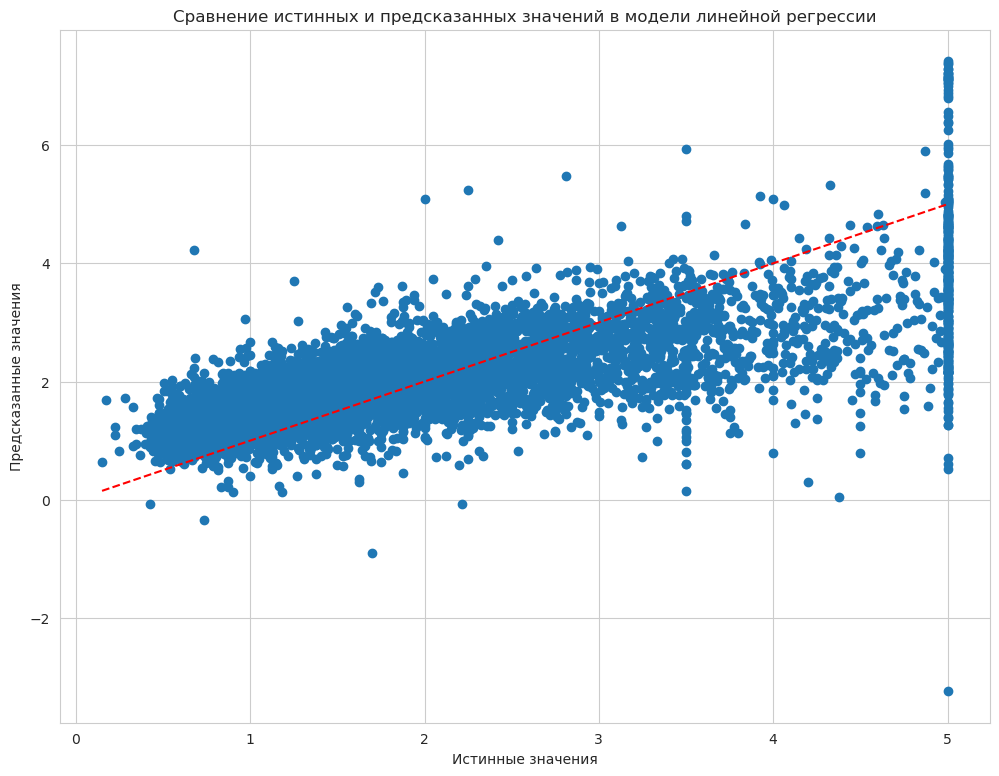

In [33]:
plt.scatter(y_test, y_pred)
plt.title('Сравнение истинных и предсказанных значений в модели линейной регрессии')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red');

#### Самые значимые предикторы

Посмотрим на самый значимый предиктор:

В нашем случае это `MedInc`, т.е. средний доход в "блоке"

Далее идет `HouseAge`, т.е. средний возраст дома

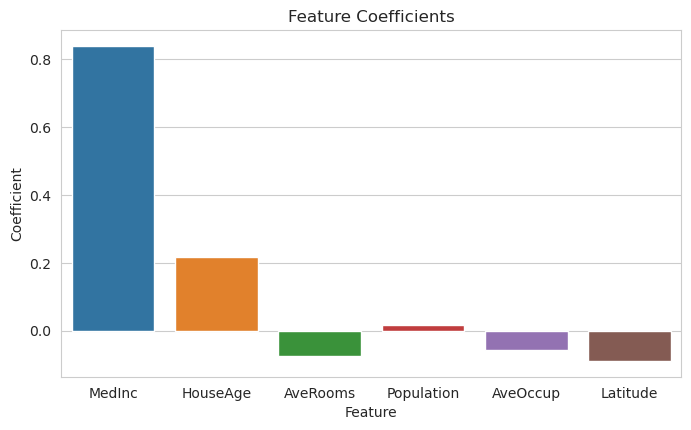

In [34]:
predictors = pd.DataFrame({'Feature': X_subset_columns,
                           'Coefficient': linmod_pipeline.named_steps['linmod'].coef_})
plt.figure(figsize=(8, 4.5))
plt.title('Feature Coefficients')
sns.barplot(x='Feature', y='Coefficient', data=predictors, hue='Feature');

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справить с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [35]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    return 1 / (1 + np.exp(-output))

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [36]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    return (-1 / n) * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return np.transpose(X) @ (y_pred - y_true)


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [37]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        y_pred = sigmoid(X_test @ self.W)

        return y_pred
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [38]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

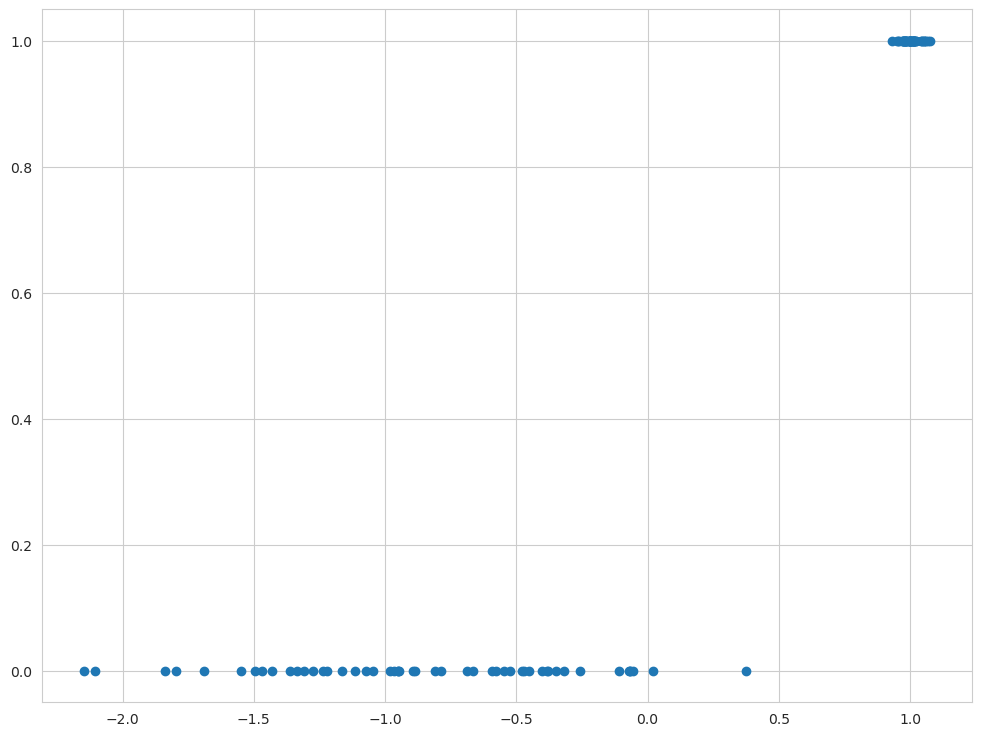

In [39]:
plt.scatter(X, y);

In [40]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

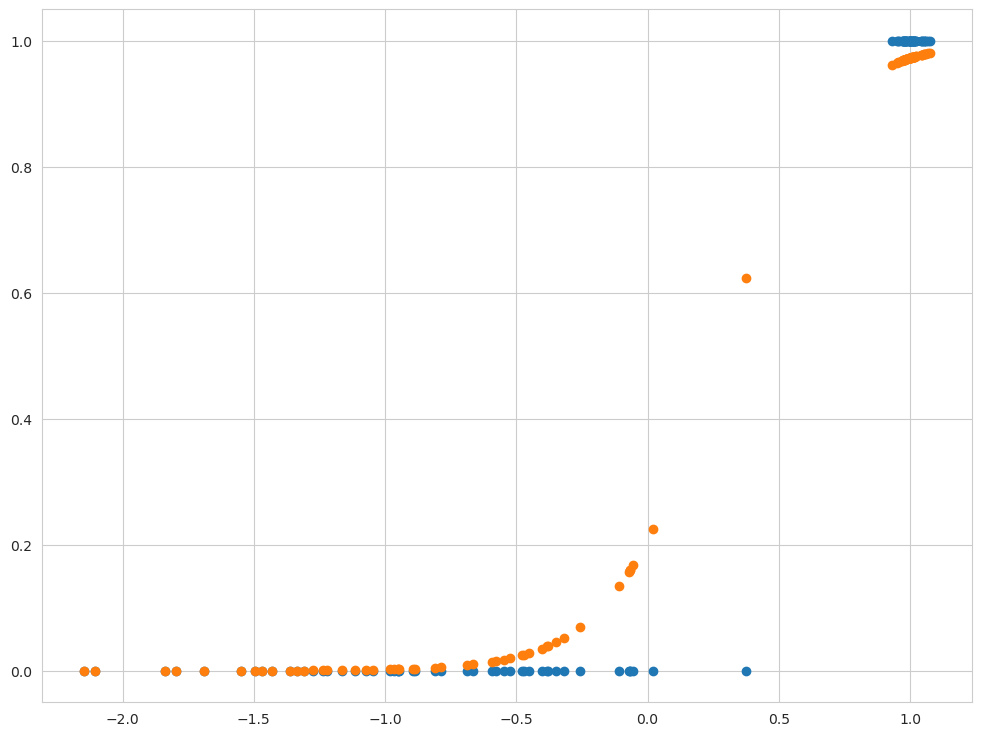

In [41]:
plt.scatter(X, y)
plt.scatter(X, y_pred);

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

In [42]:
print(f'BCE: {bce(y, y_pred):.4f}', 
      f'ROC AUC: {roc_auc_score(y, y_pred):.4f}',
      sep='\n')

BCE: 232.0807
ROC AUC: 1.0000


#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

In [43]:
pokemon = pd.read_csv("../data_folder/raw_data/Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


#### EDA

In [44]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [45]:
pokemon.describe()

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,362.813750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,208.343798,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.000000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,184.750000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,364.500000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,539.250000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,721.000000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


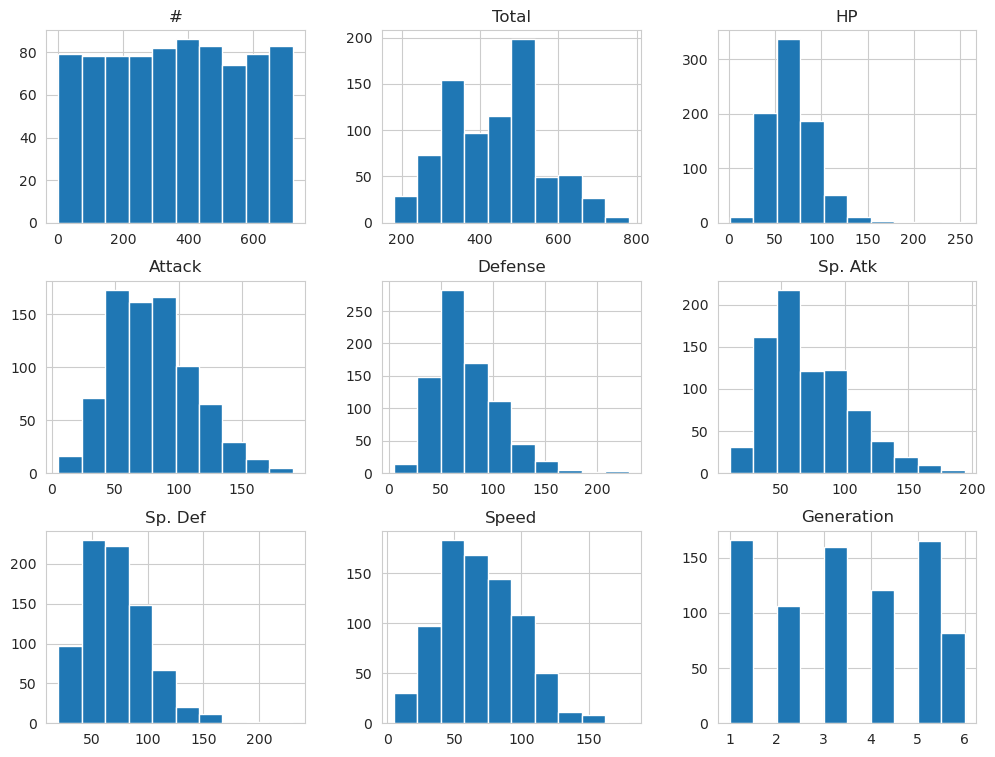

In [46]:
pokemon.hist();

Данная гистограмма не затронула наш <u>таргет</u>, поэтому посмотрим на него вручную:

In [47]:
pokemon.Legendary.value_counts()

Legendary
False    735
True      65
Name: count, dtype: int64

Для оценки корреляции я убираю колонки `#`, `Name`, `Type 1`, `Type 2` и `Generation`, потому что:
- первая является просто id'шником
- 2-3 это нечисленные признаки
- последняя является факторной переменной

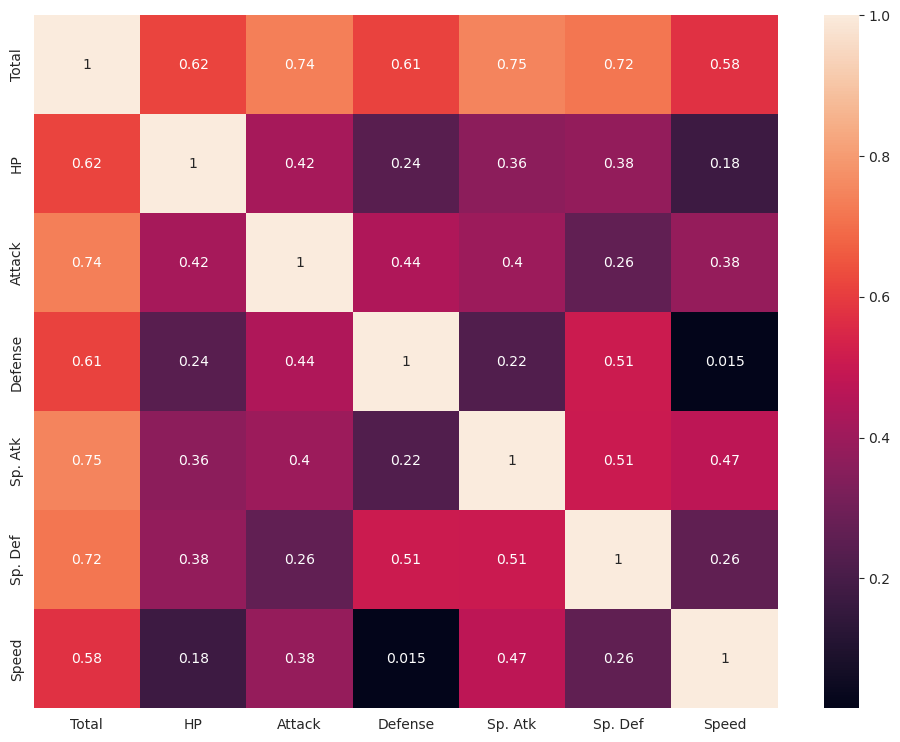

In [48]:
pokemon_num_cols = pokemon.iloc[:, 4:11]
sns.heatmap(pokemon_num_cols.corr(), annot=True);

По какой-то причине моя старая EDA'шка не работает на этом датасете (я обязательно сделаю новый вариант!), поэтому для оценки <u>выбросов</u> напишем простенькую функцию:

In [49]:
for i in range(pokemon_num_cols.shape[1]):
    pokemon_subset = pokemon_num_cols.iloc[:, i]
    q1 = np.percentile(pokemon_subset, 25)
    q3 = np.percentile(pokemon_subset, 75)
    iqr = q3 - q1
    threshold = 1.5 * iqr
    outliers = np.where((pokemon_subset < q1 - threshold) | (pokemon_subset > q3 + threshold))
    print(f'Number of outliers in "{pokemon_num_cols.columns[i]}" is: {len(outliers[0])}')

Number of outliers in "Total" is: 0
Number of outliers in "HP" is: 19
Number of outliers in "Attack" is: 7
Number of outliers in "Defense" is: 13
Number of outliers in "Sp. Atk" is: 10
Number of outliers in "Sp. Def" is: 7
Number of outliers in "Speed" is: 2


**Информация об атрибутах:**

- #: ID for each pokemon
- Name: Name of each pokemon
- Type 1: Each pokemon has a type, this determines weakness/resistance to attacks
- Type 2: Some pokemon are dual type and have 2
- Total: sum of all stats that come after this, a general guide to how strong a pokemon is
- HP: hit points, or health, defines how much damage a pokemon can withstand before fainting
- Attack: the base modifier for normal attacks (eg. Scratch, Punch)
- Defense: the base damage resistance against normal attacks
- SP Atk: special attack, the base modifier for special attacks (e.g. fire blast, bubble beam)
- SP Def: the base damage resistance against special attacks
- Speed: determines which pokemon attacks first each round

**EDA саммари:**

- Распределение атрибутов следующее:
  - dtypes: bool(1), int64(9), object(3)
- Много пропущенных значений в колонке `Type 2` $\rightarrow$ можно попробовать создать новый признак, отвечающий за наличие двух типов
- У многих признаков отличающиеся размерности $\rightarrow$ нужна стандартизация
- Выбросов не очень много, к тому же они могут ими не быть (у Легендарных покемонов статы могут быть выше)
- Каких-то супер-сильных корреляций не обнаружено
- В таргете обнаружен сильный перекос (НЕ Легендарных покемонов сильно меньше, чем Легендарных)

Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

#### Построение модели

In [50]:
pokemon[['Legendary']] = pokemon[['Legendary']].astype(int)
pokemon['Two types'] = pokemon['Type 2'].notna().astype(int)

In [51]:
cat_cols = ['Generation', 'Two types']
num_cols = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
all_features = cat_cols + num_cols

target = pokemon['Legendary'].values

X = pokemon[all_features]
y = target

Разделите ваши данные на тестовую и тренировочную выборку.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=SEED)

Обучите модель `LogisticRegression` из `sklearn`.

In [53]:
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(drop="first"), cat_cols)
])
preprocessor

ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk',
                                  'Sp. Def', 'Speed']),
                                ('ohe', OneHotEncoder(drop='first'),
                                 ['Generation', 'Two types'])])

In [54]:
logmod_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("logmod", LogisticRegression())
])
logmod_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Total', 'HP', 'Attack',
                                                   'Defense', 'Sp. Atk',
                                                   'Sp. Def', 'Speed']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['Generation',
                                                   'Two types'])])),
                ('logmod', LogisticRegression())])

In [55]:
logmod_pipeline.fit(X_train, y_train)
y_pred = logmod_pipeline.predict(X_test)
y_pred_prob = logmod_pipeline.predict_proba(X_test)

Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

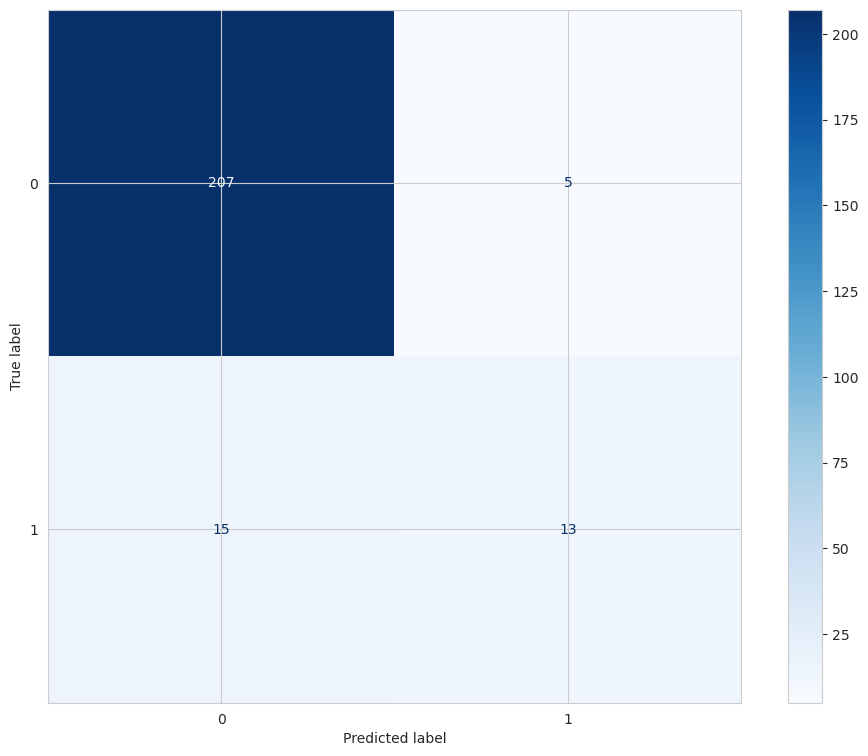

In [56]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues');

In [57]:
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}',
      f'Precision: {precision_score(y_test, y_pred):.4f}',
      f'Recall: {recall_score(y_test, y_pred):.4f}',
      f'F_1: {f1_score(y_test, y_pred):.4f}',
      sep='\n')

Accuracy: 0.9167
Precision: 0.7222
Recall: 0.4643
F_1: 0.5652


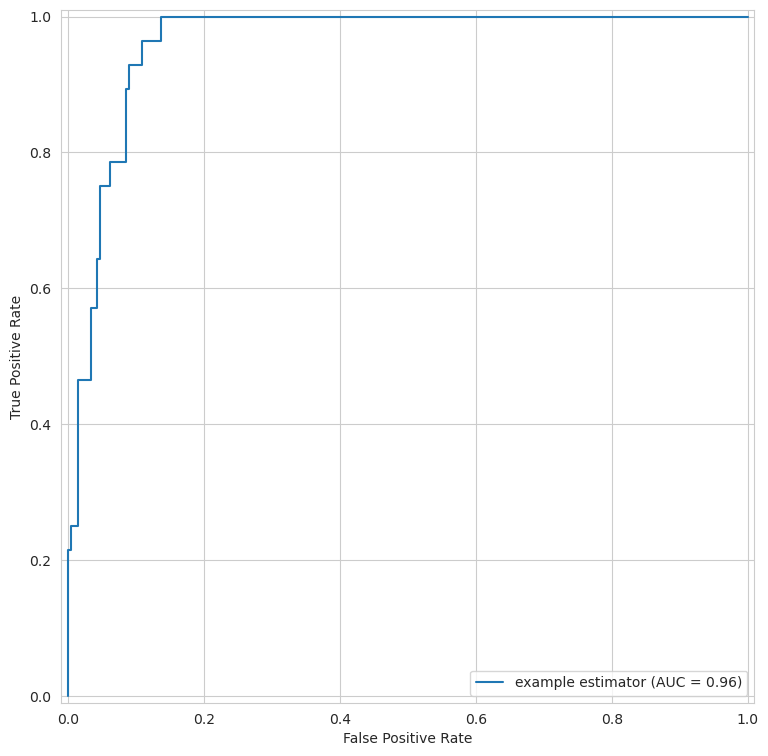

In [58]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator').plot();

AUC = 0.96 и Accuracy = 0.9167 говорит о том, что данная модель хорошая

Однако, Recall = 0.4643 говорит о том, что модель плохо предсказывает "легендарных" покемонов. Это может быть связано с перекосом в данных.

#### Самые значимые предикторы

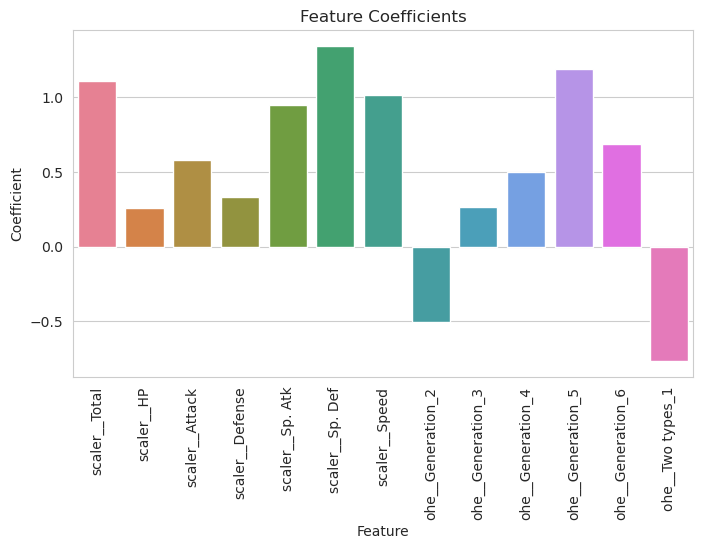

In [59]:
predictors = pd.DataFrame({'Feature': preprocessor.get_feature_names_out(),
                           'Coefficient': logmod_pipeline.named_steps['logmod'].coef_.flatten()})
plt.figure(figsize=(8, 4.5))
plt.title('Feature Coefficients')
plt.xticks(rotation=90)
sns.barplot(x='Feature', y='Coefficient', data=predictors, hue='Feature');

In [60]:
predictors.sort_values('Coefficient')

,Feature,Coefficient
12,ohe__Two types_1,-0.764491
7,ohe__Generation_2,-0.504737
1,scaler__HP,0.255171
8,ohe__Generation_3,0.267509
3,scaler__Defense,0.331351
9,ohe__Generation_4,0.496415
2,scaler__Attack,0.580659
11,ohe__Generation_6,0.686535
4,scaler__Sp. Atk,0.949334
6,scaler__Speed,1.015343


Наиболее значимые предикторы:
- Sp. Def
- Generation_5
- Total
- Speed

### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

Не то чтобы у меня была прям самая любимая музыкальная группа, я в принципе много чего слушаю, но если уж зашел разговор, то на ум приходит Skillet.

Их песни мне показал друг из школы в далеком 2012 году. Раньше очень много их слушал, но сейчас лишь иногда включаю.

[Skillet $-$ Monster](https://www.youtube.com/watch?v=1mjlM_RnsVE)

[Skillet - Hero](https://www.youtube.com/watch?v=uGcsIdGOuZY)

[Skillet - Comatose](https://www.youtube.com/watch?v=JZNCrLV8W_M)

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

За счет того, что в этот раз было гораздо больше написанного кода, было проще.

Для статистики: я потратил на всё дз 7 часов (почти в 2 раза меньше, чем на первую!!)